#Lab 6: Training neural networks (part 2/2)
**Like always, remember to set Runtime environment to GPU**

In this second part of lab 6 we will explore more tools that will help you train your own neural networks. This time we will be using convolutional neural networks (CNNs). 


##1. Download the CIFAR 10 dataset
We will be using the CIFAR 10 dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

mean = 0.5
std = 0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean, mean, mean), (std, std, std))])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

 99%|█████████▊| 168173568/170498071 [00:17<00:00, 16627308.90it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Display some stats

num_train 49984
num_test 9984
images.shape torch.Size([64, 3, 32, 32])


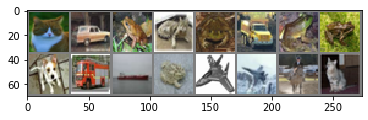

  cat   car  frog   cat  frog truck  frog  frog   dog truck  ship  frog plane plane horse   cat


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy() / 2 + 0.5 # Un-normalize
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Number of samples
num_train = bs * len(trainloader)
num_test = bs * len(testloader)
print('num_train',num_train)
print('num_test',num_test)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('images.shape',images.shape)

# show 16 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

##2. Task 1 (optional): Setting up your CNN
**You can skip this task and jump directly to Task 3, if you feel comfortable with PyTorch and the different layer types used in CNNs.**

Here, we will set up our own CNN. For this purpose we will need the following layer types:

- https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d
- https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d
- https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d
- https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU
- https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
- https://pytorch.org/docs/stable/nn.html#torch.nn.Linear

as well as the reshape operation (called `view` in PyTorch):

- https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view

Let's see how each of these work:

In [0]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

###2.1 Conv2d
Reference to documentation: https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d

In [4]:
# Print shape of input
print('Input dimensions are (batch_size, channels, height, width)')
print('images.shape',images.shape)

# Perform convolution
conv = nn.Conv2d(3, 6, 5)
x = conv(images)

# Print shape of output
print('x.shape',x.shape)

# Print parameter shapes
for name, param in conv.named_parameters(): print('parameter',name,param.shape)

Input dimensions are (batch_size, channels, height, width)
images.shape torch.Size([64, 3, 32, 32])
x.shape torch.Size([64, 6, 28, 28])
parameter weight torch.Size([6, 3, 5, 5])
parameter bias torch.Size([6])


####2.1.1 Questions
1. What do each of the parameters (3, 6, 5) mean?
2. Recall the formula to calculate the output size of a convolution: 

 `output_size = (input_size - kernel_size) / stride + 1`

 or as defined in the slides (Lecture 5 slide 48):

 `output_size = (N - W) / stride + 1`

 Is this formula satisfied in the above example?
3. How could you make the output (x) have the same width and height as the input (images)? (Think "padding"...)
4. If the convolution operation performed above was a layer in a CNN, what would the number of parameters of that layer be?

####2.1.2 Answers
1. `(in_channels, out_channels, kernel_size) = (3, 6, 5)`, where `in_channels` is the number of channels of the input (3 here because input is a color image), `out_channels` is the number of feature meaps that will be generated, and `kernel_size` is the filter size.
2. Yes. We have `N = 32`, `W = kernel_size = 5`, `stride = 1` (default), so theoretically `output_size = (32-5)/1 + 1 = 28`, which matches the shape of `x`.
3. `Conv2d` has a padding option. By setting `padding = 2`, the output has the same width/height as the input (see code below). The formula for calculating the right padding size is (see slide 52 of lecture 5): `padding = (W-1)/2 = (5-1)/4 = 2`.
4. For the filter weights the number of parameters is `out_channels * kernel_size^2 = 6 * 5 * 5 = 150`. In addition there is one bias parameters for each output, totalling `150 + 6 = 156` parameters.

In [5]:
# Code for question 2: Padding
conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
x = conv(images)

# Width and height are the same
print('x.shape',x.shape)
print('images.shape',images.shape)

x.shape torch.Size([64, 6, 32, 32])
images.shape torch.Size([64, 3, 32, 32])


###2.2 MaxPool2d
Reference to documentation: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

In [6]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

# Perform max pool
pool = nn.MaxPool2d(2, 2)
y = pool(x)
print('y.shape',y.shape)

# Print some elements
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])
print('y[0,0,0:2,0:2]:\n',y[0,0,0:2,0:2])

y.shape torch.Size([64, 6, 14, 14])
x[0,0,0:4,0:4]:
 tensor([[ 0.2602, -1.1193, -1.1787,  0.3233],
        [-1.0601, -1.1990, -0.4385,  0.9522],
        [ 0.8623,  0.4489, -1.0869,  0.8856],
        [ 0.8705, -0.8600,  1.3529,  0.4730]])
y[0,0,0:2,0:2]:
 tensor([[0.2602, 0.9522],
        [0.8705, 1.3529]])


####2.2.1 Questions
1. What does MaxPool2d do? (Explain the output `y[0,0,0:2,0:2]` and compare to `x[0,0,0:2,0:2]`)
2. What do each of the parameters (2, 2) mean?

####2.2.2 Answers
1. It downscales the input along the widht and height dimensions. It does so by running a "window" over the input. For each window it outputs the maximum value within the window. In the example above, the window size is 2x2, and the window is shifted to pixels. Hence, the output `y` is half the width/height of the input `x`, and the output values are the maxima of the corresponding window of the input.
2. The first parameter is the window size (or kernel_size), and the second parameter is the stride (i.e., how many pixel the window position is shifted).

###2.3 BatchNorm2d
Reference to documentation: https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d

In [7]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)*10 + 2
print('x.mean',x.mean())
print('x.std',x.std())

# Perform batch normalization
bn = nn.BatchNorm2d(6)
y = bn(x)
print('y.mean',y.mean())
print('y.std',y.std())

# Print parameter shapes
for name, param in bn.named_parameters(): print('parameter',name,param.shape)

x.mean tensor(1.9998)
x.std tensor(10.0014)
y.mean tensor(-2.1287e-09, grad_fn=<MeanBackward0>)
y.std tensor(1.0000, grad_fn=<StdBackward0>)
parameter weight torch.Size([6])
parameter bias torch.Size([6])


####2.3.1 Questions
1. What does BacthNorm2D do?
2. What does the input parameter (6) mean?
3. Is the mean and standard deviation after batch normalization as expected?
4. How many parameters does BatchNorm2D have? Why?

####2.3.2 Answers
1. For each batch, it normalizes the values of the input according to the equation found in the documentation (and slides of lecture 6). The normalization is based on a standard score `y=(x-mean(x))/std(x)`, with the addition of two learnable parameters that can revert the standard score to produce the identity function if necessary. So the final equation becomes `y = gamma*(x-mean(x))/std(x) + beta` and with `gamma=std(x)` and `beta=mean(x)`, we get the identity function `y=x`. The initial values of the parameters are `gamma=1` and `beta=0`. 
2. It is `num_features` – `C` from an expected input of size `(N, C, H, W)`.
3. The mean and standard deviation of output `y` should be 0 and zero, respectively.
4. It has 2x6: a gamma and a beta for each input channel.

###2.4 ReLU
Reference to documentation: https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU

In [8]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)
print('x.min',x.min())
print('x.max',x.max())
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])

# Apply ReLU
y = F.relu(x)
print('y.min',y.min())
print('y.max',y.max())
print('y[0,0,0:4,0:4]:\n',y[0,0,0:4,0:4])

x.min tensor(-4.4178)
x.max tensor(4.5902)
x[0,0,0:4,0:4]:
 tensor([[-1.6375, -0.5160,  1.4666, -1.6623],
        [ 1.5573, -0.0163,  0.7239, -1.8672],
        [ 0.2729, -0.9187,  1.3387, -0.4404],
        [ 1.0167,  0.1649, -1.7314,  0.1249]])
y.min tensor(0.)
y.max tensor(4.5902)
y[0,0,0:4,0:4]:
 tensor([[0.0000, 0.0000, 1.4666, 0.0000],
        [1.5573, 0.0000, 0.7239, 0.0000],
        [0.2729, 0.0000, 1.3387, 0.0000],
        [1.0167, 0.1649, 0.0000, 0.1249]])


####2.4.1 Question
1. What does ReLU do? (Explain the output `y[0,0,0:4,0:4]` and compare to `x[0,0,0:4,0:4]`)

####2.4.2 Answers
1. It sets all negative values to zero. That's it.

###2.5 Linear and view
Reference to documentation:
- https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
- https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view

Recall that CNNs for classification are divided into two blocks:

1. **Convolutional base (encoder):** A sequence of convolutional layers resulting in a feature map that you may think of as a multi-dimensional image with a certain width, height, and depth (number of channels).
2. **Fully connected layers (decoder):** One or more fully connected layers ending with a classifier.

The input to the decoder has to be a vector with the correct dimensions. Thus, our task is to convert the feature map into a vector. In the code below we wish to take the feature map `x`, vectorize it, and feed it through a fully connected layer to produce 10-dimensional output.

Your task is to figure out, what value `N` should have (see helper questions below):

In [9]:
# Random input - dimensions are (batch_size, channels, height, width) 
x = torch.randn(64,6,28,28)

N = 6*28*28 # Solution

# Vectorize
y = x.view(-1, N)
print('y.shape',y.shape)

# Fully connected layer
fc = nn.Linear(N,10)
z = fc(y)
print('z.shape',z.shape)

y.shape torch.Size([64, 4704])
z.shape torch.Size([64, 10])


The correct output shape (of z) is [64, 10], where 64 is the batch size and 10 is the dimensionality we want in the output side of the fully connected layer.

####2.5.1 Helper questions
1. What does `view` do?
2. What does `Linear` do?


####2.5.2 Answers
1. `view` returns a new tensor with the same data as the input tensor but of a different shape. Our input has shape `(64,6,28,28)`, where the dimensions are `(batch_size, channels, height, width)`. When vectorizing this, we want to keep the batch dimensions, so the output should have size `(64,6*28*28)`, so `N = 6*28*28 (= 4704)`.
2. `Linear` applies a linear transformation to the incoming data: `y = Wx + b`, where `x` has shape `(batch_size, in_features)`, and the output has shape `(batch_size, out_features)`. Therefore, the parameters of `Linear` are `(in_features, out_features)`. Here we have `in_features = N = 6*28*28`.


##2.6 Dropout
Reference to documentation: https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout

Dropout is normally used only in relation to fully connected layers (i.e., not convolutional layers). The example below demonstrates the effect of the Dropout layer: 

In [10]:
# Random input - dimensions are (batch_size, num_in_features) 
x = torch.randn(64,10)
print('x[0,:]',x[0,:])

drop = nn.Dropout(p=0.5)
y = drop(x)
print('y[0,:]',y[0,:])

print('ratios',y[0,:]/x[0,:])

x[0,:] tensor([ 1.3175, -0.2960, -0.8038,  0.8372,  1.3758,  1.0163, -0.2350, -0.6890,
        -2.7419, -0.8317])
y[0,:] tensor([ 2.6351, -0.0000, -1.6076,  0.0000,  2.7516,  0.0000, -0.0000, -0.0000,
        -0.0000, -1.6634])
ratios tensor([2., 0., 2., 0., 2., 0., 0., 0., 0., 2.])


**IMPORTANT NOTE:** If necessary, re-run the code block until the printed part of `y[0,:]` contains both zeros and non-zeroes.

####2.6.1 Questions
1. Explain why there are zeroes in `y`.
2. Ratios: Why are the values of the non-zero entries of `y` twice as high as the corresponding values of the input `x`?
3. What happens to the ratios if you set `p=0.75`?

####2.6.2 Answers
1. Applying Dropout has the affect of setting elements to zero with a certain probability `p`. In other words the output `y` will be identical to input `x`, except that a fraction `p` of the elements (roughly) are set to zero.
2. When using Dropout in the context of a neural network, we apply Dropout only during training, but not during testing/evaluation. So if `p=0.5` half of the neurons will be inactive during training, but not during testing. To compensate for this, we can scale the output `y` by `1/(1-p)` during training. In this example `1/(1-p) = 1/0.5 = 2`, so the non-zero elements of `y` are twice is high as the corresponding elements of input `x`.
3. The ratios become `4` instead of `2`(see code below) because `1/(1-0.75) = 1/0.25 = 4`.

In [11]:
# Setting p = 0.75, the ratio become 4
drop = nn.Dropout(p=0.75)
y = drop(x)
print('ratios',y[0,:]/x[0,:])

ratios tensor([0., 4., 0., 0., 4., 4., 0., 4., 4., 4.])


##2.7 Setting up the model
Your task is to fill in the blanks (???) below.

Hint: You can insert print statements in the `forward` function, which is executed when calling `scores = model(images)`.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=16) # num_features = 6 because conv2 has out_channels = 16
        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120) # in_features = 16*5*5 because output shape of previous layer is 16x5x5 (see code below)
        self.fc2 = nn.Linear(in_features=120, out_features=10) # in_features = 120 becuase out_features of previous layer is 120

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model = Net()

print('Network architecture:\n')
print(model)

# Print parameter shapes
print('Network parameters:\n')
for name, param in model.named_parameters(): print('parameter',name,param.shape)

# Test model
scores = model(images)
print(scores.shape)

Network architecture:

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
Network parameters:

parameter conv1.weight torch.Size([6, 3, 5, 5])
parameter conv1.bias torch.Size([6])
parameter bn1.weight torch.Size([6])
parameter bn1.bias torch.Size([6])
parameter conv2.weight torch.Size([16, 6, 5, 5])
parameter conv2.bias torch.Size([16])
parameter bn2.weight torch.Size([16])
parameter bn2.bias torch.Size([16])
parameter fc1.weight torch.Size([120, 400])
parameter fc1.bias torch.Size([120])
parame

Example code to find shape of input to first fully connected layer:

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=16) # num_features = 6 because conv2 has out_channels = 16
        self.drop = nn.Dropout(p=0.5)
        #self.fc1 = nn.Linear(in_features=???, out_features=120) # in_features = 16*5*5 because output shape of previous layer is 16x5x5 (see code below)
        #self.fc2 = nn.Linear(in_features=???, out_features=10) # in_features = 120 becuase out_features of previous layer is 120

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        print(x.shape)
        #x = x.view(-1, ???)
        #x = self.drop(x)
        #x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc2(x)
        return x

model = Net()

# Test model
x = model(images)
print(x.shape)

torch.Size([64, 16, 5, 5])
torch.Size([64, 16, 5, 5])


##3. Task 2: Training the model
In this task, just run the code, observe what happens and do your best to understand it.

In [0]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

###3.1 Setting up the CNN model
First, lets set up a simple CNN with 2 convolutional layers, followed by two fully connected layers. The network is equivalent to the network defined above in Task 2. Each convolution operation is followed by batch normalization, ReLU, and max pooling (Note that instead of max pooling we could also have applied convolution with a stride of 2 to achieve the same level of down-sizing). The self-made Lambda layer helps us reshape the output if the last conv layer to a vector, because PyTorch has no built-in reshape layer. We perform dropout on this vector with p = 0.5, before applying the two fully connected layers.

In [15]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def Net():
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=0.5),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

model = Net()

print('Network parameters:\n')
print(model)

# Print parameter shapes
for name, param in model.named_parameters(): print('parameter',name,param.shape)

Network parameters:

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Lambda()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=400, out_features=120, bias=True)
  (11): ReLU()
  (12): Linear(in_features=120, out_features=10, bias=True)
)
parameter 0.weight torch.Size([6, 3, 5, 5])
parameter 0.bias torch.Size([6])
parameter 1.weight torch.Size([6])
parameter 1.bias torch.Size([6])
parameter 4.weight torch.Size([16, 6, 5, 5])
parameter 4.bias torch.Size([16])
parameter 5.weight torch.Size([16])
parameter 5.bias torch.Size([16])
parame

Here is a neat function that you can call to re-initialize the weights/parameters of the model:

In [0]:
def reset_parameters(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1) # Why 1?
            torch.nn.init.constant_(m.bias, 0) # Why 0?
        elif isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)

reset_parameters(model)

###3.2 Testing the model
Let's test the model:

In [17]:
# Move data to GPU
images = images.cuda()
labels = labels.cuda()

# Calculate scores
model = Net().cuda()
scores = model(images)  # predictions

print(scores.shape)

torch.Size([64, 10])


###3.3 Calculating the accuracy
The scores (logits) don't have any meaningful interpretation, but we can convert them into class probabilities using softmax. Since we are only going to be interested in the model's accuracy, we will wrap the softmax inside function accuracy that calculates the accuracy on a batch:

In [18]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

print('Accuracy', accuracy(scores,labels))

Accuracy tensor(0.0938, device='cuda:0')


###3.4 Calculating the loss
I order to train your model, we also need a loss function. We will use the cross entropy loss already provided in PyTorch:

In [19]:
loss_func = F.cross_entropy
loss = loss_func(scores, labels)
print('Loss', loss)

Loss tensor(2.2816, device='cuda:0', grad_fn=<NllLossBackward>)


###3.5 Training function (fit)
The code below can be used to train a model and monitor important stats as training progresses. The training is carried out by calling the `fit` function, which takes any model as input.

You can change the optimizer by replacing `base_optimizer` with your own function handle.

The function `base_lr_scheduler` is a learning rate scheduler that updates the learning rate of the optimizer during training. Here it does does nothing, but you can modify it to implement your own learning rate scheduler. The inputs are
- `T` : Total number of batches
- `t` : Current batch index (max(t) = T)
- `lr` : Current learning rate

Other parameters to `fit` are:
- `bs` the batch size
- `epochs` the number of epochs
- `batches_per_epoch` the number of batches per epoch. If set to `None`, all images in the dataset are used.

Note that you can use `batches_per_epoch` to reduce the size of the training set. The effective size of the training set is `bs*batches_per_epoch`.

In [0]:
from torch import optim

# Function handle that returns an optimizer
def base_optimizer(model,lr=0.001, momentum=0.9):
    return optim.SGD(model.parameters(), lr=lr,momentum=momentum)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def base_lr_scheduler(t,T,lr):
  return lr

# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  # Initialize optimizer
  opt = opt_func(model)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs
  
  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)
  
  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss)
    plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      pred = model(xb.cuda())
      loss = loss_func(pred, yb.cuda())

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

      # Validation loss and accuracy
      if t % 10 == 0:    # print every 10 mini-batches
        model.eval() # Test mode
        with torch.no_grad():
            valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss_history.append(valid_loss)
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        model.train() # Back to train mode

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    l, = plt.plot(plot_time_valid,valid_loss_history)
    lines.append(l)
    labels.append('Validation')  
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history

###3.6 Train the model
Train the model and inspect the loss curves.

Epochs: 1 Batches per epoch: 196 Total number of batches 196
t 10 lr 0.001 train loss 3.2575645 val loss 2.5470831 val accuracy 0.101464845
t 20 lr 0.001 train loss 2.991659 val loss 2.4059865 val accuracy 0.14130859
t 30 lr 0.001 train loss 2.6617684 val loss 2.31293 val accuracy 0.16777344
t 40 lr 0.001 train loss 2.6992767 val loss 2.2266707 val accuracy 0.19169922
t 50 lr 0.001 train loss 2.5381608 val loss 2.165895 val accuracy 0.21064453
t 60 lr 0.001 train loss 2.5045903 val loss 2.1269975 val accuracy 0.22148438
t 70 lr 0.001 train loss 2.4309404 val loss 2.0992575 val accuracy 0.23144531
t 80 lr 0.001 train loss 2.3004797 val loss 2.0721476 val accuracy 0.24160157
t 90 lr 0.001 train loss 2.4009812 val loss 2.0483863 val accuracy 0.25078127
t 100 lr 0.001 train loss 2.2360427 val loss 2.0332057 val accuracy 0.25478515
t 110 lr 0.001 train loss 2.3501687 val loss 2.0204637 val accuracy 0.2578125
t 120 lr 0.001 train loss 2.21033 val loss 2.00771 val accuracy 0.2611328
t 130 lr 

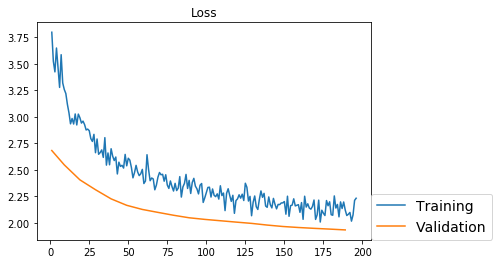

In [21]:
# Re-initialize weights
reset_parameters(model) 

# Train with defaul settings.
train_loss_history = fit(model)

**Note:** For some reason, which is not exactly clear to me, the train loss and validation loss are scaled differently, so you cannot compare them directly. It has something to do with dropout, but I am not exactly sure how to fix it. As a result the validation loss curve will in most cases be lower than the training loss curve.

###3.7 Performing quick experiments on reduced dataset
When searching for hyperparameters it is often useful to perform quick experiments on only a small subset of the data. You can do this by decreasing the batch size and setting `batches_per_epoch` to say 20. The effective size of the training set is then `bs*batches_per_epoch` (say `128*20 = 2,560`), and the total number of batches being processed during training is `bs*batches_per_epoch*epochs` (say `128*20*5 = 51,200`).


Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.0155902 val loss 2.6150014 val accuracy 0.104687504
t 20 lr 0.001 train loss 3.0730224 val loss 2.3425474 val accuracy 0.1515625
t 30 lr 0.001 train loss 2.689754 val loss 2.3454034 val accuracy 0.17031251
t 40 lr 0.001 train loss 2.5305023 val loss 2.253294 val accuracy 0.1875
t 50 lr 0.001 train loss 2.5223486 val loss 2.163476 val accuracy 0.196875
t 60 lr 0.001 train loss 2.548517 val loss 2.1162605 val accuracy 0.215625
t 70 lr 0.001 train loss 2.3966124 val loss 2.0877903 val accuracy 0.2234375
t 80 lr 0.001 train loss 2.2051885 val loss 2.066946 val accuracy 0.2265625
t 90 lr 0.001 train loss 2.2961967 val loss 2.0471134 val accuracy 0.2390625
t 100 lr 0.001 train loss 2.2797916 val loss 2.029548 val accuracy 0.246875


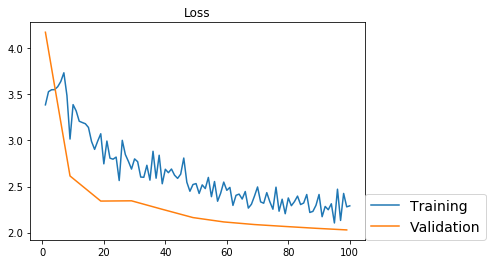

In [22]:
# Re-initialize weights
reset_parameters(model)

# Example: Train on small subset
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###3.7 Train with custom optimizer
Fell free to experiment with these optimizers.

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.1 train loss 2.2681305 val loss 2.2945867 val accuracy 0.134375
t 20 lr 0.1 train loss 2.2224295 val loss 2.146941 val accuracy 0.1921875
t 30 lr 0.1 train loss 2.1566288 val loss 2.092414 val accuracy 0.2296875
t 40 lr 0.1 train loss 2.0581467 val loss 2.016073 val accuracy 0.284375
t 50 lr 0.1 train loss 2.027801 val loss 1.9014091 val accuracy 0.29375002
t 60 lr 0.1 train loss 1.8567736 val loss 1.8991202 val accuracy 0.2953125
t 70 lr 0.1 train loss 1.8734639 val loss 1.8494459 val accuracy 0.3234375
t 80 lr 0.1 train loss 1.7531364 val loss 1.772054 val accuracy 0.3203125
t 90 lr 0.1 train loss 1.8317988 val loss 1.7281588 val accuracy 0.3703125
t 100 lr 0.1 train loss 1.8930515 val loss 1.7474245 val accuracy 0.35


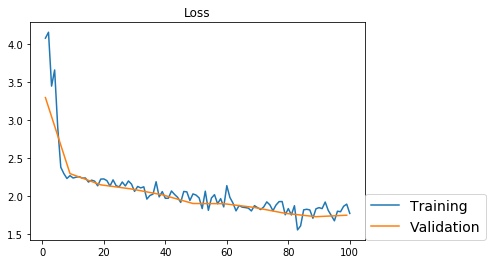

In [23]:
#SGD + Momentum
def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Adagrad
def adagrad_optimizer(model):
  return optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.0, weight_decay=0.0, initial_accumulator_value=0)

# RMSProp
def rmsprop_optimizer(model):
  return optim.RMSprop(model.parameters(), lr=0.1, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# Adam
def adam_optimizer(model):
  return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Train with custom optimizer (on small subset)
reset_parameters(model) # Reset network weights
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

##4. Tasks: You are free to choose any of the tasks below
The overall goal is to make the model perform is good as possible on the CIFAR 10 dataset. Solving the tasks below might help you, but feel free to try other options. For inspiration, here is a list of other things, you could do:

- **Increase the capacity of the network** (add more conv layers, add more kernels in each layer, add another fully connected layer, add more connections in the fully connected layer, etc.)
- **Experiment with weight decay** (weight decay is an option for, say, the [SGD optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD))

General recommendations for hyperparameter search (see Lecture 6 slides):
- Stage your search from course to fine
- Start with a small sample (subset) of the dataset to tune in on hyperparameters such as learning rate, and start with 1 epoch or less
- The second stage could then perform a narrower search with more data and/or more epochs
- Search for learning rates in powers of 10. Good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4, etc.)
- **Look at loss curves!!!**


###4.1 Implement a learning rate scheduler
**Your task** is to replace the function `base_lr_scheduler` with your own `step_decay` function (or another type of learning rate scheduler if you prefer). In step decay the lerning rate is updated for every `step` batches according to the rule `lr = lr * decay_rate`. The input `t` is the current batch index, ranging from 1 to `T`, where `T = batches_per_epoch * epochs` is the total number of batches.

**Solution:**

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.280987 val loss 2.409346 val accuracy 0.1375
t 20 lr 0.0009000000000000001 train loss 3.0414007 val loss 2.4520779 val accuracy 0.14375
t 30 lr 0.0008100000000000001 train loss 2.7515347 val loss 2.452491 val accuracy 0.13906251
t 40 lr 0.000729 train loss 2.7944539 val loss 2.3715303 val accuracy 0.15468751
t 50 lr 0.0006561000000000001 train loss 2.5914543 val loss 2.3051245 val accuracy 0.1765625
t 60 lr 0.00059049 train loss 2.6059585 val loss 2.2613113 val accuracy 0.19375001
t 70 lr 0.000531441 train loss 2.539638 val loss 2.237378 val accuracy 0.20625
t 80 lr 0.0004782969 train loss 2.6632695 val loss 2.2147362 val accuracy 0.20625
t 90 lr 0.00043046721 train loss 2.654896 val loss 2.1911829 val accuracy 0.215625
t 100 lr 0.000387420489 train loss 2.5295432 val loss 2.173198 val accuracy 0.221875


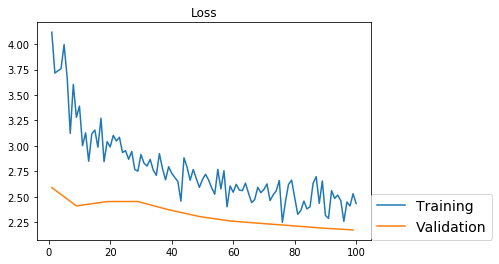

In [24]:
def step_decay(t,T,lr,step=10,decay_rate=0.9):
  if t % step == 0:
    lr = lr * decay_rate
  return lr

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=step_decay,bs=128,epochs=5,batches_per_epoch=20)

**Sub-tasks:**
- What new hyperparameters are added with learning rate decay?
- See if you can make the model perform better with learning rate decay.

**Comment/answer:**
- Two more hyperparameters are added: `step` and `decay_rate`

###4.2 Implement a learning rate finder
Finding a good initial learning rate can be done efficiently with a learning rate finder. Here is the basic idea:

You can modify the learning rate scheduler `base_lr_scheduler` to use a hardcoded list of learning rates. This can be uses to implement a learning rate finder according to this principle:
- Start training and increase learning rate linearly after each batch (!!!), and calculate the loss
- Then display the loss as a function of learning rate.
- By manual inspection, select a suitable range of learning rates by locating the strongest downward slope.

Say the hardcoded learning rates are:

In [0]:
# Random un-ordered list of learning rates
lr_list = [0.1,0.5,0.01]

Then simply implement a learning rate scheduler that returns the t´th entry of the learning rate list:

In [0]:
def lr_finder(t,T,lr):
  return lr_list[t-1]

Note, the learning rate scheduler must have this interface: `(t,T,lr)`

Then train the model for as many batches as there are entries in the learning rate list:

In [27]:
# Make sure that we process as many batches as there are learning rates in our list:
batches_per_epoch = len(lr_list)
epochs = 1

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)

Epochs: 1 Batches per epoch: 3 Total number of batches 3


Plot the loss versus learning rate and inspect:

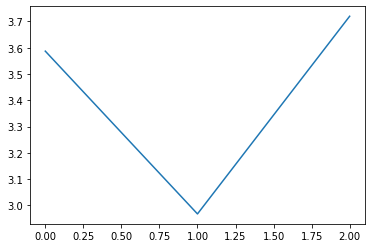

In [28]:
plt.figure()
plt.plot(train_loss_history)

**Your task** is to implement a learning rate finder that searches through a range of learning rates, like above.

The range of learning rates should be logarithmic (say from 10^-6 to 10^1). You can define the list of learning rates using `np.logspace`.

Then plot the loss versus the learning rate. It is a good idea to use a logarithmic scale on the x-axis (see `plt.xscale('log')`).

####4.2.1 My solution

[1.00000000e-06 1.38949549e-06 1.93069773e-06 2.68269580e-06
 3.72759372e-06 5.17947468e-06 7.19685673e-06 1.00000000e-05
 1.38949549e-05 1.93069773e-05 2.68269580e-05 3.72759372e-05
 5.17947468e-05 7.19685673e-05 1.00000000e-04 1.38949549e-04
 1.93069773e-04 2.68269580e-04 3.72759372e-04 5.17947468e-04
 7.19685673e-04 1.00000000e-03 1.38949549e-03 1.93069773e-03
 2.68269580e-03 3.72759372e-03 5.17947468e-03 7.19685673e-03
 1.00000000e-02 1.38949549e-02 1.93069773e-02 2.68269580e-02
 3.72759372e-02 5.17947468e-02 7.19685673e-02 1.00000000e-01
 1.38949549e-01 1.93069773e-01 2.68269580e-01 3.72759372e-01
 5.17947468e-01 7.19685673e-01 1.00000000e+00 1.38949549e+00
 1.93069773e+00 2.68269580e+00 3.72759372e+00 5.17947468e+00
 7.19685673e+00 1.00000000e+01]
Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 1.3894954943731361e-05 train loss 4.330286 val loss 2.8943055 val accuracy 0.08894231
t 20 lr 0.0003727593720314938 train loss 4.053942 val loss 2.9292736 val accuracy 0

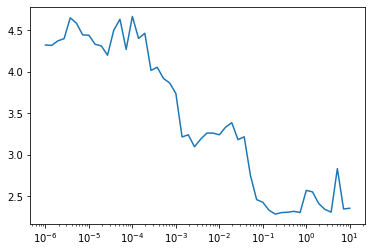

In [29]:
batches_per_epoch = 50
lr_list = np.logspace(-6,1,batches_per_epoch) # Your code goes here
print(lr_list)

# Run
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xscale('log') # Use log scale on x-axis

**Comments:**
Seems like the optimal learning rate is somewhere between 10^-3 and 10^-1 (look for steepest slope).

**Additional sub-task:** Can you come up with a simple way to implement Cyclic Learning Rate (CLR) based on the above?

Hint: Run training multiple times using a carefully selected list of learning rates each time.

####4.2.2 My solution
Train 4 cycles, and in each cycle use 50 learning rates from 10^-3 to 10^-1.

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.0021209508879201904 train loss 3.0248702 val loss 2.341122 val accuracy 0.095853366
t 20 lr 0.005428675439323859 train loss 2.714747 val loss 2.3136182 val accuracy 0.09615385
t 30 lr 0.013894954943731374 train loss 2.293948 val loss 2.2893894 val accuracy 0.11628606
t 40 lr 0.03556480306223128 train loss 2.0368967 val loss 2.2278256 val accuracy 0.22746395
t 50 lr 0.09102981779915217 train loss 1.9387608 val loss 2.1803913 val accuracy 0.20342548


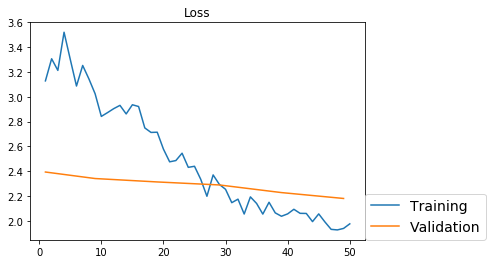

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.0021209508879201904 train loss 1.9191777 val loss 2.1282341 val accuracy 0.22445914
t 20 lr 0.005428675439323859 train loss 1.8750657 val loss 2.0272012 val accuracy 0.25570914
t 30 lr 0.013894954943731374 train loss 1.8238635 val loss 1.8847641 val accuracy 0.31820914
t 40 lr 0.03556480306223128 train loss 1.8652098 val loss 1.842271 val accuracy 0.3266226
t 50 lr 0.09102981779915217 train loss 1.8478076 val loss 1.7983466 val accuracy 0.3224159


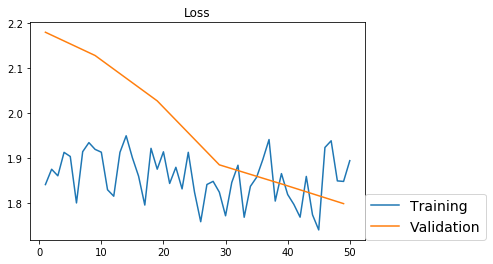

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.0021209508879201904 train loss 1.7919645 val loss 1.745421 val accuracy 0.34735578
t 20 lr 0.005428675439323859 train loss 1.716977 val loss 1.7303373 val accuracy 0.35757214
t 30 lr 0.013894954943731374 train loss 1.7543689 val loss 1.7184373 val accuracy 0.35877407
t 40 lr 0.03556480306223128 train loss 1.7257559 val loss 1.669464 val accuracy 0.3816106
t 50 lr 0.09102981779915217 train loss 1.7477318 val loss 1.7476894 val accuracy 0.3422476


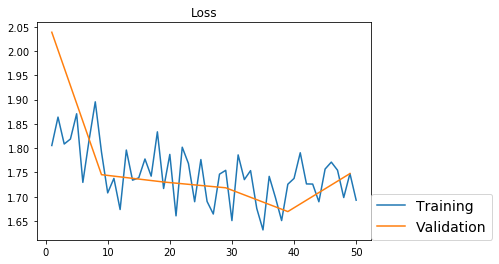

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.0021209508879201904 train loss 1.6658978 val loss 1.664401 val accuracy 0.36508414
t 20 lr 0.005428675439323859 train loss 1.6871696 val loss 1.6307251 val accuracy 0.39393032
t 30 lr 0.013894954943731374 train loss 1.6717283 val loss 1.6545106 val accuracy 0.37920675
t 40 lr 0.03556480306223128 train loss 1.6701853 val loss 1.6188933 val accuracy 0.4002404
t 50 lr 0.09102981779915217 train loss 1.6553457 val loss 1.6170031 val accuracy 0.40985578


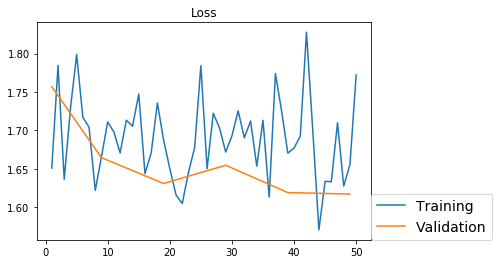

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.0021209508879201904 train loss 1.5991913 val loss 1.6016511 val accuracy 0.4125601
t 20 lr 0.005428675439323859 train loss 1.7154194 val loss 1.5708023 val accuracy 0.4263822
t 30 lr 0.013894954943731374 train loss 1.6050767 val loss 1.5720606 val accuracy 0.42007214
t 40 lr 0.03556480306223128 train loss 1.7061995 val loss 1.5606848 val accuracy 0.42908657
t 50 lr 0.09102981779915217 train loss 1.6292315 val loss 1.5582082 val accuracy 0.4221755


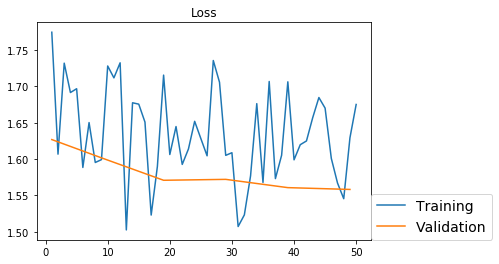

In [0]:
reset_parameters(model)
for cycle in range(5):
  lr_list = np.logspace(-3,-1,50)
  batches_per_epoch = len(lr_list)
  epochs = 1
  train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch)

###4.3 Experiment with dropout
Below is a slight modification of our model that allows changing the dropout fraction (p).

**Your task** is to experiment with different values of p.

- What does setting p = 0 mean?
- Try different values of p (say 0, 0.1, 0.5 and 0.9). What is the optimal value of p?

Note: For some reason that I haven't had time to investigate, the validation loss becomes lower and lower relative to the training loss, as you increase the value of p. This is obviously a scaling error, but I haven't debugged it.

In [0]:
def Net(p=0.5):
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=p),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

# Model with p=0.25
model = Net(p=0.25).cuda()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 2.82262 val loss 2.5637898 val accuracy 0.103125
t 20 lr 0.001 train loss 2.4502814 val loss 2.4432464 val accuracy 0.0984375
t 30 lr 0.001 train loss 2.450149 val loss 2.3394845 val accuracy 0.1171875
t 40 lr 0.001 train loss 2.2674296 val loss 2.271074 val accuracy 0.159375
t 50 lr 0.001 train loss 2.2724423 val loss 2.2361543 val accuracy 0.1765625
t 60 lr 0.001 train loss 2.2054718 val loss 2.1923301 val accuracy 0.20625
t 70 lr 0.001 train loss 2.1491036 val loss 2.1617973 val accuracy 0.215625
t 80 lr 0.001 train loss 2.232932 val loss 2.1402812 val accuracy 0.2203125
t 90 lr 0.001 train loss 2.0207155 val loss 2.1197457 val accuracy 0.2265625
t 100 lr 0.001 train loss 1.9491291 val loss 2.105114 val accuracy 0.2296875


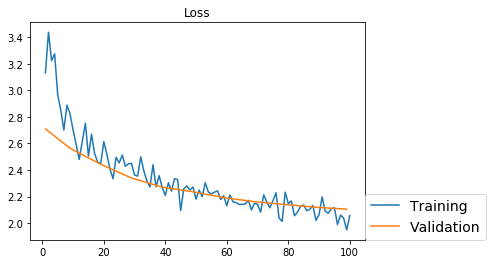

In [31]:
# p = 0 means no dropout
model = Net(p=0.0).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 6.7524266 val loss 2.4707572 val accuracy 0.09375
t 20 lr 0.001 train loss 4.789114 val loss 2.4897888 val accuracy 0.0953125
t 30 lr 0.001 train loss 4.898303 val loss 2.400025 val accuracy 0.1296875
t 40 lr 0.001 train loss 3.8628023 val loss 2.3031166 val accuracy 0.140625
t 50 lr 0.001 train loss 4.0807033 val loss 2.2186735 val accuracy 0.1734375
t 60 lr 0.001 train loss 3.4983733 val loss 2.1712701 val accuracy 0.1921875
t 70 lr 0.001 train loss 3.0777411 val loss 2.1573753 val accuracy 0.2125
t 80 lr 0.001 train loss 3.1338594 val loss 2.1504867 val accuracy 0.22500001
t 90 lr 0.001 train loss 2.8854966 val loss 2.1394908 val accuracy 0.2234375
t 100 lr 0.001 train loss 2.9773967 val loss 2.1304579 val accuracy 0.221875


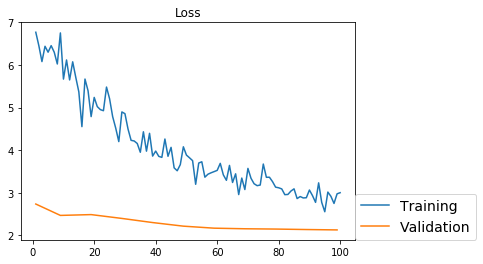

In [32]:
# p = 0.9 means "heavy dropout", which is in general a bad idea
model = Net(p=0.9).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.4032857 val loss 2.5275688 val accuracy 0.13906251
t 20 lr 0.001 train loss 3.0152926 val loss 2.4445057 val accuracy 0.1296875
t 30 lr 0.001 train loss 2.7998106 val loss 2.4106405 val accuracy 0.120312504
t 40 lr 0.001 train loss 2.634985 val loss 2.3606694 val accuracy 0.1484375
t 50 lr 0.001 train loss 2.4883163 val loss 2.294809 val accuracy 0.159375
t 60 lr 0.001 train loss 2.5278912 val loss 2.2299705 val accuracy 0.17031251
t 70 lr 0.001 train loss 2.5196557 val loss 2.1855316 val accuracy 0.1921875
t 80 lr 0.001 train loss 2.2412136 val loss 2.1522853 val accuracy 0.2109375
t 90 lr 0.001 train loss 2.601469 val loss 2.1295815 val accuracy 0.2265625
t 100 lr 0.001 train loss 2.3677528 val loss 2.1091018 val accuracy 0.23281251


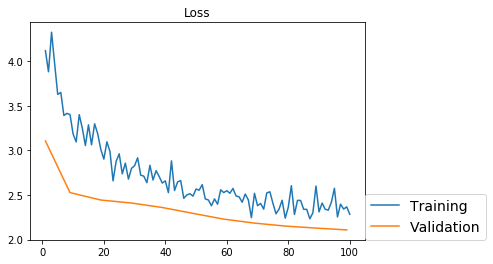

In [33]:
# p = 0.5
model = Net(p=0.5).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###4.4 Data augmentation
Adding more training data is the best way to improve your models abiliy to generalize to unseen data. Data augmentations is basically about generating additional *fake data" to expand the size of your training set.

**Your task** is to experiment with different types of data augmentation. All you have to do is change the transformer below and add some of the available transforms: https://pytorch.org/docs/stable/torchvision/transforms.html

You can find inspiration in Lab 4: https://github.com/aivclab/dlcourse/blob/master/Lab_4_(part3)_PyTorch_Transfer_Learning.ipynb


Files already downloaded and verified
Files already downloaded and verified
images.shape torch.Size([64, 3, 32, 32])


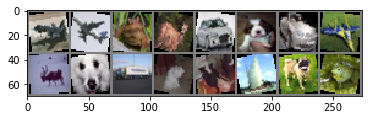

plane plane  frog  deer   car   dog   car plane  deer   dog truck   cat   cat  ship   dog  frog


In [34]:
mean = 0.5
std = 0.5
transform = transforms.Compose(
    [ # My solution
      transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given PIL Image randomly with a given probability. 
      transforms.ColorJitter(brightness=0.1), # Randomly change the brightness, contrast and saturation of an image
      transforms.RandomRotation(degrees=15), # Rotate the image by angle.
      transforms.ToTensor(),
      transforms.Normalize((mean, mean, mean), (std, std, std))
     ])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('images.shape',images.shape)

# show 10 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.201019 val loss 2.5053272 val accuracy 0.0859375
t 20 lr 0.001 train loss 3.0087426 val loss 2.5622382 val accuracy 0.125
t 30 lr 0.001 train loss 2.8244476 val loss 2.4292545 val accuracy 0.1484375
t 40 lr 0.001 train loss 2.469145 val loss 2.2945333 val accuracy 0.1890625
t 50 lr 0.001 train loss 2.5936255 val loss 2.2747436 val accuracy 0.20625
t 60 lr 0.001 train loss 2.570811 val loss 2.2480867 val accuracy 0.20625
t 70 lr 0.001 train loss 2.4135575 val loss 2.1998606 val accuracy 0.2296875
t 80 lr 0.001 train loss 2.5883386 val loss 2.1667068 val accuracy 0.2296875
t 90 lr 0.001 train loss 2.6328819 val loss 2.1623344 val accuracy 0.2453125
t 100 lr 0.001 train loss 2.4576428 val loss 2.1425617 val accuracy 0.2359375


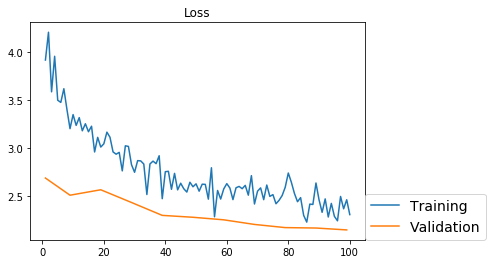

In [35]:
# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###4.5 Multi-task learning (MTL)
By sharing representations between related tasks, we can enable our model to generalize better on our original task. This is the basic idea behind MTL.

There is one additional task that we can always add, and that is an **autoencoder**. Recall that an autoencoder is basically an identity function that maps input x to itself. It does so by first encoding x into a more compact representation E(x), and then decodes this representation to get a reconstruction of x = D(E(x)), where E() is the encoder, and D() is the decoder.

The network below uses the **same encoder** to solve both a **classification task** and an **autoencoder task**.

In [0]:
# define the NN architecture
class MTLNet(nn.Module):
    def __init__(self):
        super(MTLNet, self).__init__()

        ## shared encoder layers ##
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 4, 5, stride=2, padding=2)
        
        ## decoder layers ##
        # Classifier
        self.fc1 = nn.Linear(in_features=4*8*8, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=10)

        ## Autoencoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # decoder for task 1 - outputs scores for classifier
        scores = x.view(-1, 4*8*8)
        scores = F.relu(self.fc1(scores))
        scores = self.fc2(scores)

        ## decoder for task 2 - outputs reconstruction of input x
        recon = F.relu(self.t_conv1(x))
        recon = self.t_conv2(recon)
                
        return scores, recon

# initialize the NN
model = MTLNet()

Let's look at the output of this model:

scores.shape torch.Size([64, 10])
recon.shape torch.Size([64, 3, 32, 32])

Input images:



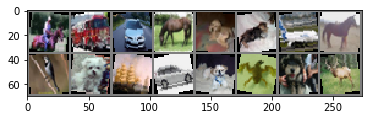

Reconstructed images:



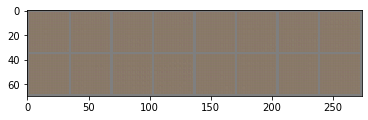

In [37]:
# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

scores,recon = model(images)
print('scores.shape',scores.shape)
print('recon.shape',recon.shape)

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))

In order to optimize our MTL model we need a loss function. However, since we are solving two tasks, we also need two terms in our loss function - one for each task.

The loss for the classification task is the familiar cross entropy:

In [38]:
# Classification loss
loss_func_1 = F.cross_entropy
loss1 = loss_func_1(scores, labels)
print('Loss 1', loss1)

Loss 1 tensor(2.2936, grad_fn=<NllLossBackward>)


A suitable loss for the autoencoder task would be the Mean Squared Error (MSE) between the input images (say `images`) and the networks reonstruction (say `recon`): 

In [39]:
# MSE loss for reconstruction
loss_func_2 = F.mse_loss
loss2 = loss_func_2(images,recon)
print('Loss 2', loss2)

Loss 2 tensor(0.3089, grad_fn=<MeanBackward0>)


Below is a modified function to fit the MTL model.

**Your task** is simply to fill in the missing code (marked with ???).

This is not as trivial as you might think (hint: do the two losses have the same scale?).

In [0]:
# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None,
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)
  
  loss1_history = []
  loss2_history = []
  plot_time_train = []
  
  # Initialize optimizer
  opt = opt_func(model)

  t = 1 # Index of current batch
  T = batches_per_epoch * epochs # Total number of batches
  
  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)
  
  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      scores,recon = model(xb.cuda())
      loss1 = loss_func_1(scores, yb.cuda())
      loss2 = loss_func_2(recon, xb.cuda())
      
      loss = loss1 + loss2

      if t % 10 == 0:    # print every 10 mini-batches
        print('loss1',loss1.detach().cpu().numpy(),'loss2',loss2.detach().cpu().numpy())

      loss1_history.append(loss1.detach().cpu().numpy())
      loss2_history.append(loss2.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,loss1_history)
    lines.append(l)
    labels.append('Loss1 (classification)')
    l, = plt.plot(plot_time_train,loss2_history)
    lines.append(l)
    labels.append('Loss2 (autoencoder)')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
loss1 2.2556603 loss2 0.29024532
loss1 2.2466116 loss2 0.27841306
loss1 2.2202854 loss2 0.26397482
loss1 2.1158786 loss2 0.26396433
loss1 2.121718 loss2 0.2694783
loss1 2.1137414 loss2 0.26185054
loss1 2.0388725 loss2 0.28036168
loss1 2.1379821 loss2 0.27102628
loss1 2.1523435 loss2 0.2739917
loss1 2.0927796 loss2 0.2762337


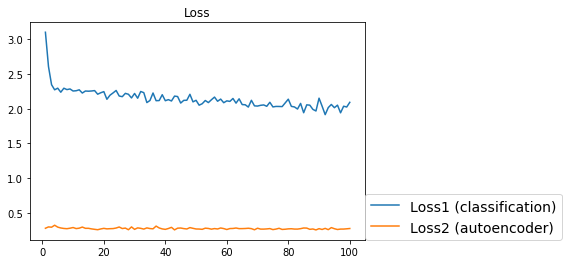

In [41]:
model = MTLNet().cuda()

# Re-initialize weights
reset_parameters(model)

def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Example (in practise you need more epochs than 5)
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

**Comments:**
- Here I set loss = loss1 + loss2, but clearly loss1 is much higher than loss2.
- To balance them out we could set loss = loss1 + 10*loss2:

In [0]:
# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None,
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)
  
  loss1_history = []
  loss2_history = []
  plot_time_train = []
  
  # Initialize optimizer
  opt = opt_func(model)

  t = 1 # Index of current batch
  T = batches_per_epoch * epochs # Total number of batches
  
  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)
  
  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      scores,recon = model(xb.cuda())
      loss1 = loss_func_1(scores, yb.cuda())
      loss2 = 10 * loss_func_2(recon, xb.cuda())
      
      loss = loss1 + loss2

      if t % 10 == 0:    # print every 10 mini-batches
        print('loss1',loss1.detach().cpu().numpy(),'loss2',loss2.detach().cpu().numpy())

      loss1_history.append(loss1.detach().cpu().numpy())
      loss2_history.append(loss2.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,loss1_history)
    lines.append(l)
    labels.append('Loss1 (classification)')
    l, = plt.plot(plot_time_train,loss2_history)
    lines.append(l)
    labels.append('Loss2 (autoencoder)')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
loss1 2.2984455 loss2 3.1296954
loss1 2.306975 loss2 2.8932981
loss1 2.2988563 loss2 2.4879086
loss1 2.3003428 loss2 2.7031913
loss1 2.2689424 loss2 2.8156664
loss1 2.3251245 loss2 2.6489997
loss1 2.2287605 loss2 2.6941168
loss1 2.2852728 loss2 2.5231652
loss1 2.296314 loss2 2.1996527
loss1 2.2800546 loss2 1.6127366


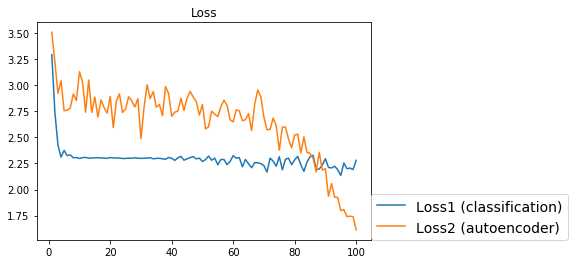

In [43]:
model = MTLNet().cuda()

# Re-initialize weights
reset_parameters(model)

def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Example (in practise you need more epochs than 5)
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

**Comment:** Looks better! Now, train for more epochs.

Epochs: 50 Batches per epoch: 20 Total number of batches 1000
loss1 2.1170642 loss2 1.4134573
loss1 2.0603604 loss2 1.2737502
loss1 2.1612005 loss2 1.2058676
loss1 1.9613608 loss2 1.135752
loss1 2.0529542 loss2 1.0936644
loss1 2.0880585 loss2 1.1484843
loss1 1.9665396 loss2 1.1824701
loss1 2.063169 loss2 1.0358372
loss1 1.9269263 loss2 1.0651267
loss1 1.9989033 loss2 1.039179
loss1 1.8926032 loss2 0.99517936
loss1 2.003853 loss2 1.1133034
loss1 2.0394905 loss2 1.0923805
loss1 1.9285374 loss2 1.0597789
loss1 1.9515545 loss2 0.9914047
loss1 2.0049644 loss2 1.0541406
loss1 2.038371 loss2 0.98839885
loss1 1.881421 loss2 1.0366728
loss1 1.906086 loss2 0.96805716
loss1 1.7081867 loss2 1.1621099
loss1 1.9130979 loss2 1.0328368
loss1 1.9997876 loss2 0.98295087
loss1 1.8071346 loss2 0.96552765
loss1 1.7977146 loss2 1.048419
loss1 1.8666672 loss2 1.0618196
loss1 1.9788321 loss2 1.00091
loss1 1.8400621 loss2 1.0124578
loss1 1.9499516 loss2 1.1126288
loss1 1.9315594 loss2 1.1156216
loss1 1.824243 

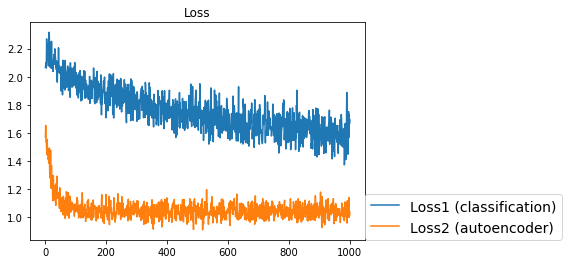

In [44]:
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=50,batches_per_epoch=20)

We should probably train for longer, but let's evaluate:

accuracy tensor(0.3521, device='cuda:0')

Input images:



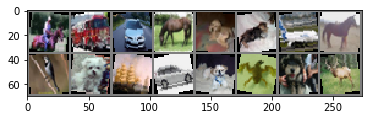

Reconstructed images:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


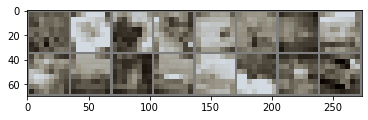

In [45]:
scores,recon = model(images.cuda())

# validation accuracy
acc = 0
for xb, yb in testloader:
  scores,recon = model(xb.cuda())
  acc += accuracy(scores,yb.cuda())
print('accuracy',acc/len(testloader))

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))